## Ships classification

In [52]:
from typing import Any
import re
from functools import lru_cache
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

#### Context

Load data from the State Ship Register of Ukraine <a href="https://data.gov.ua/dataset/bec5a0cc-76bf-4c2d-bb2e-9db3e6c01dec/resource/99f84a43-f4a2-488f-907f-f9435dd9471a/download/state_ship_register_of_ukraine.xlsx">Link</a><br>
<b>Publisher</b>: Державна служба морського і внутрішнього водного транспорту та судноплавства України
https://data.europa.eu/data/datasets/bec5a0cc-76bf-4c2d-bb2e-9db3e6c01dec?locale=en

#### Load and prepare data

In [150]:
df = pd.read_csv('state_ship_register_of_ukraine.csv')
columns = ['Тип судна', 'Довжина, м', 'Ширина, м', 'Висота, м',
           'Валова місткість, од', 'Матеріал корпусу',
           'Потужність головних механізмів', 'Кількість головних механізмів, од']
df = df[columns]

In [107]:
df

,Тип судна,"Довжина, м","Ширина, м","Висота, м","Валова місткість, од",Матеріал корпусу,Потужність головних механізмів,"Кількість головних механізмів, од"
0,Гідроцикл,0.00,0.00,0.00,0.00,NaN,0,0
1,Прогулянкове,3-Jul,Jan-22,0.40,0.00,Склопластик,155,1
2,самохідне,56.30,11.00,Apr-44,916.00,Сталь,574,2
3,самохідне,56.04,11.00,Apr-44,916.00,Сталь,574,2
4,НЕСАМОХІДНЕ,41.70,9-Feb,Mar-40,372.00,Сталь,0,0
...,...,...,...,...,...,...,...,...
41560,водолазний бот,19,3.8,2.1,35,сталь,1=150 к.с.,1
41561,несамохідне,56.47,13.5,3,750.5,сталь,2х397 кВт,2
41562,"Стоянкове, плавкафе",32,8.2,1.8,225.6,сталь,NaN,NaN
41563,риболовне,50.04,9.3,5.16,842,сталь,589 кВТ,1


In [4]:
category_columns = ['Тип судна', 'Матеріал корпусу']
float_columns = ['Довжина, м', 'Ширина, м', 'Висота, м', 'Валова місткість, од']

# Modifiers
def to_float(s: any) -> float:
    try:
        return float(s)
    except:
        return 0.0

def power_to_kw(p: any) -> float:
    """
    Extract power value in kilowatt
    Example values:
        1472      - raw value
        1820 кВт  - kilowatt value
        386 К.С.  - horsepower = 0.745 kW
        450 к. с. - horsepower with extra spaces
        немає     - empty value
 
    Args:
        p (string): power string repr
 
    Returns:
        float
    """

    try:
        return float(p)
    except:
        pass
    
    power_str = str(p).strip().lower()
    
    if power_str in ['немає', '', '-']:
        return 0.0
        
    power_reg = r'(\d+(?:\.\d+)?)\D*(квт|к\. ?с)+?'

    f = re.findall(power_reg, power_str)

    if not f:
        # print(power_str)
        return -1.0
    
    match = f[0]
    if match[1] == '' or match[1] == 'квт':
        return float(match[0])
    return float(match[0]) * 0.745


In [152]:
# Format required columns
df2 = df.copy()

for column in category_columns:
    df2[column] = df2[column].apply(lambda s: str(s).strip().lower())

for column in float_columns:
    df2[column] = df2[column].apply(to_float)

df2['Потужність головних механізмів'] = df2['Потужність головних механізмів'].apply(power_to_kw)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41565 entries, 0 to 41564
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Тип судна                          41565 non-null  object 
 1   Довжина, м                         41505 non-null  float64
 2   Ширина, м                          41551 non-null  float64
 3   Висота, м                          41421 non-null  float64
 4   Валова місткість, од               41149 non-null  float64
 5   Матеріал корпусу                   41565 non-null  object 
 6   Потужність головних механізмів     41417 non-null  float64
 7   Кількість головних механізмів, од  41422 non-null  object 
dtypes: float64(5), object(3)
memory usage: 2.5+ MB


In [154]:
# Filter columns
df3 = df2[df2['Кількість головних механізмів, од'].isin(['0', '1', '2', '3'])]
df3 = df3[(df3['Довжина, м'] > 0.0) & (df3['Довжина, м'] < 1000) & (df3['Ширина, м'] > 0.0) & (df3['Ширина, м'] < 100)]
df3 = df3[df3['Потужність головних механізмів'] >= 0]
print(df3.shape)

df3['Тип судна'] = df3['Тип судна'].astype('string')
df3['Тип судна'].value_counts()

(8911, 8)


Тип судна
самохідне моторне, прогулянкове                      2456
несамохідне                                          1555
суховантажні                                          684
самохідне                                             500
самохідне моторне, прогулянкове, водяний мотоцикл     350
                                                     ... 
суховантаж/dry cargo                                    1
генвантаж/general cargo                                 1
пасажисрьке спк                                         1
стоянкове, наливне                                      1
буксир-кантувальник                                     1
Name: count, Length: 357, dtype: Int64

<Axes: ylabel='Тип судна'>

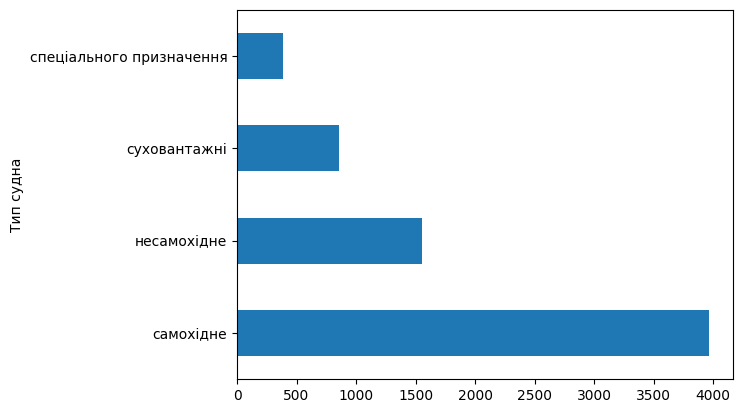

In [155]:
# Leave only 4 classes
df4 = df3.copy()
df4['Тип судна'] = df4['Тип судна'].replace('^самохідне.*','самохідне',regex=True)
df4['Тип судна'] = df4['Тип судна'].replace('^суховантаж.*','суховантажні',regex=True)
df4['Тип судна'] = df4['Тип судна'].replace('^спеціального призначення.*','спеціального призначення',regex=True)
df4 = df4[df4['Тип судна'].isin(['самохідне', 'несамохідне', 'суховантажні', 'спеціального призначення'])]
df4['Тип судна'].value_counts().plot(kind="barh")

In [168]:
# Fix types
df4 = df4[df4['Матеріал корпусу'].isin(['сталь', 'залізобетон', 'склопластик'])]
df4['Кількість головних механізмів, од'] = df4['Кількість головних механізмів, од'].astype('int')
df4['Тип судна'] = df4['Тип судна'].astype('category')
df4['Матеріал корпусу'] = df4['Матеріал корпусу'].astype('category')
df4['Висота, м'] = df4['Висота, м'].fillna(0)
df4['Валова місткість, од'] = df4['Валова місткість, од'].fillna(0)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5746 entries, 2 to 41561
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Тип судна                          5746 non-null   category
 1   Довжина, м                         5746 non-null   float64 
 2   Ширина, м                          5746 non-null   float64 
 3   Висота, м                          5746 non-null   float64 
 4   Валова місткість, од               5746 non-null   float64 
 5   Матеріал корпусу                   5746 non-null   category
 6   Потужність головних механізмів     5746 non-null   float64 
 7   Кількість головних механізмів, од  5746 non-null   int64   
dtypes: category(2), float64(5), int64(1)
memory usage: 325.8 KB


#### Visualization

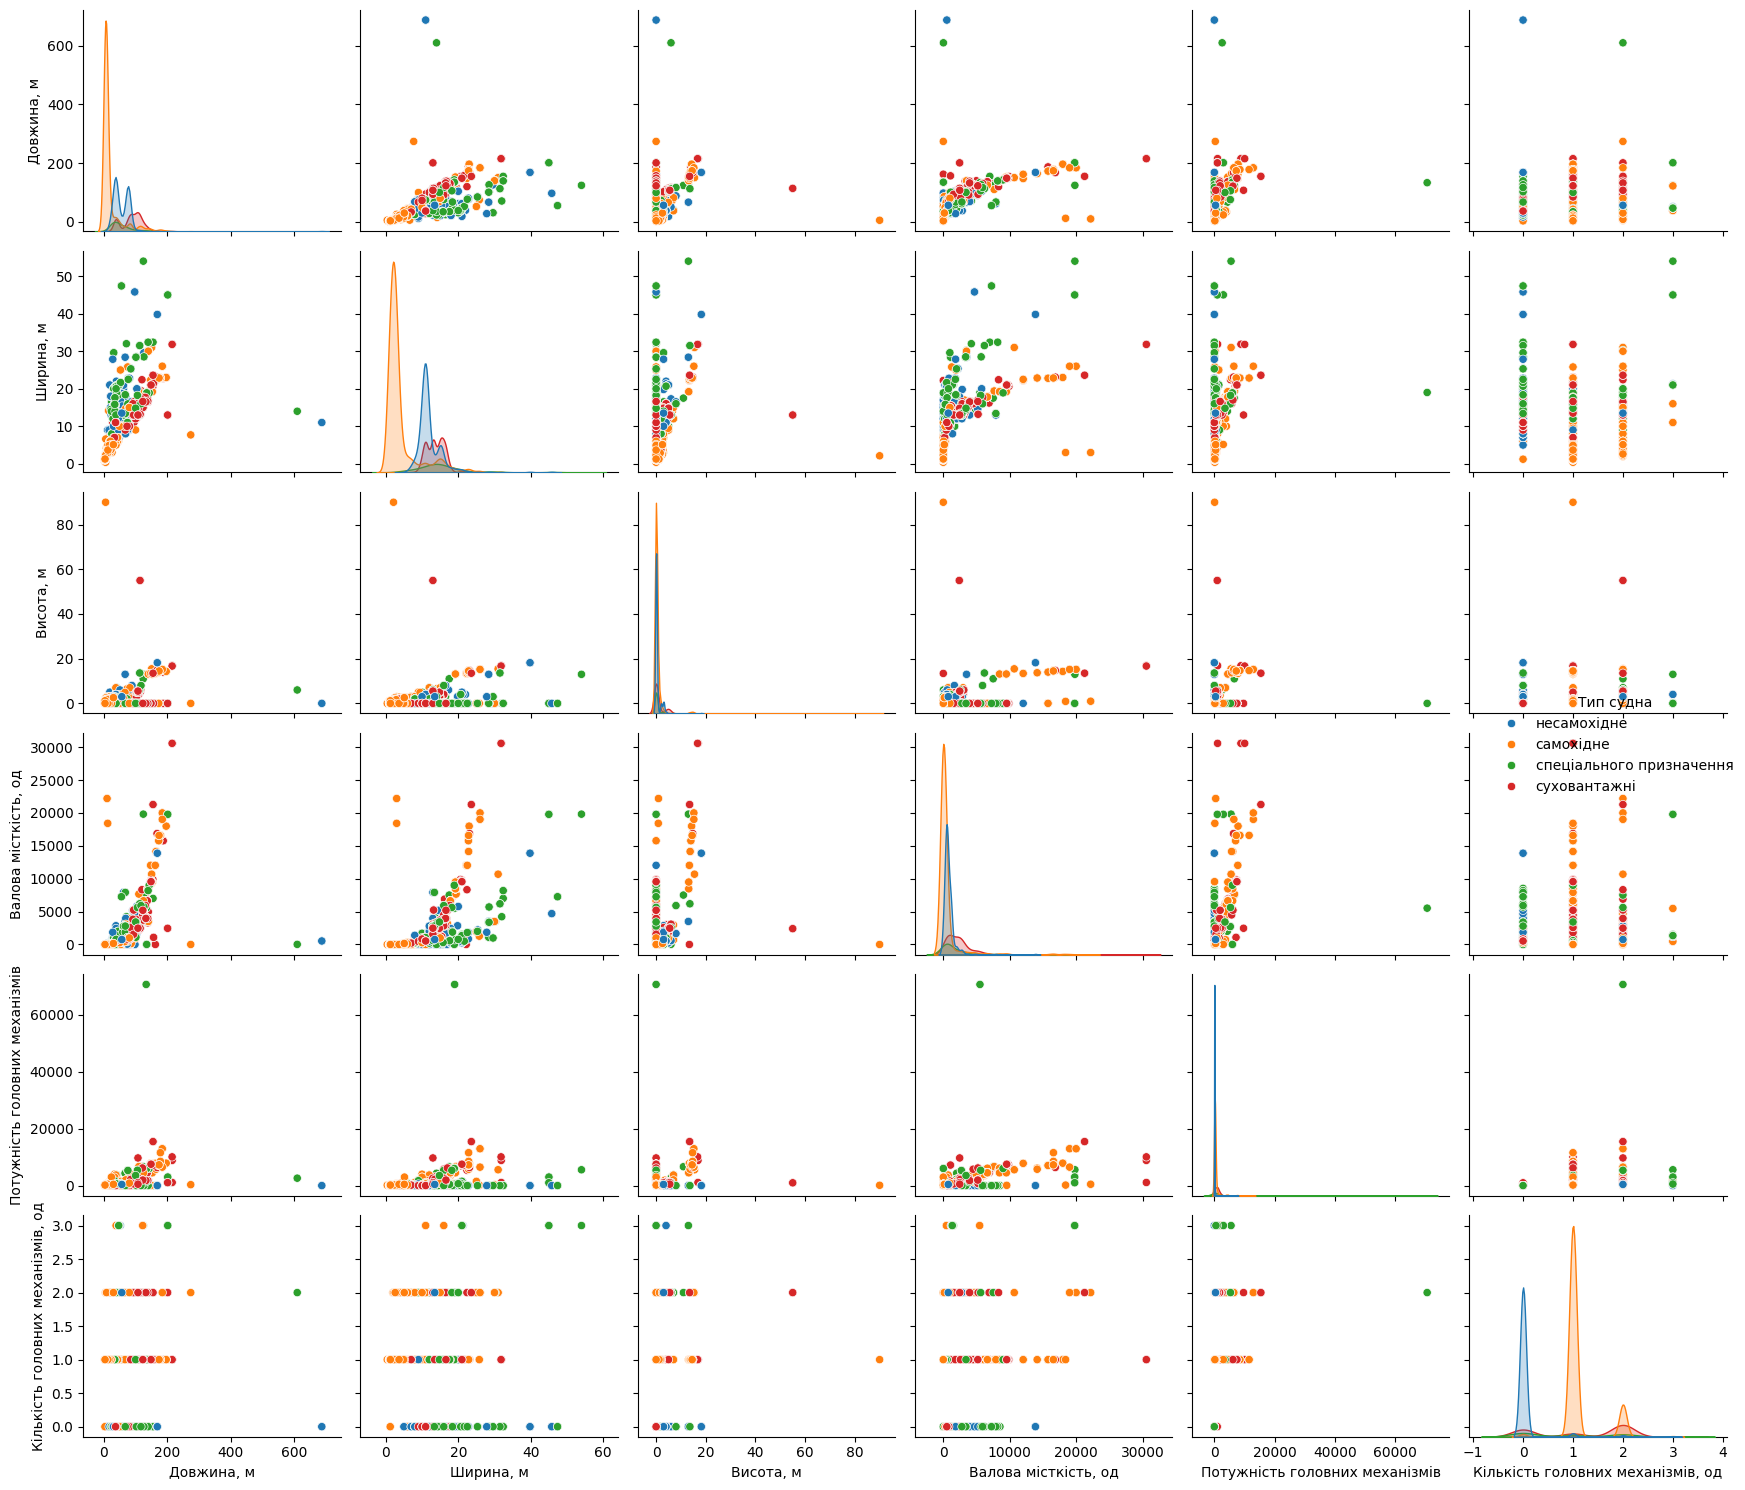

In [169]:
sns.pairplot(df4 ,hue = "Тип судна")
plt.tight_layout()
plt.show()

#### Preprocessing

In [172]:
df4.describe()

,"Довжина, м","Ширина, м","Висота, м","Валова місткість, од",Потужність головних механізмів,"Кількість головних механізмів, од"
count,5746.000000,5746.000000,5746.000000,5746.000000,5746.000000,5746.000000
mean,41.454353,8.429875,0.546851,961.896420,438.184493,0.833275
std,42.412604,6.397209,2.390311,2244.132293,1474.370088,0.704613
min,2.230000,0.400000,0.000000,0.000000,0.000000,0.000000
25%,6.050000,2.400000,0.000000,0.000000,0.000000,0.000000
50%,33.420000,10.000000,0.000000,263.000000,100.575000,1.000000
75%,73.680000,13.000000,0.000000,969.000000,242.000000,1.000000
max,687.500000,54.000000,90.000000,30575.000000,70640.000000,3.000000


In [179]:
X = df4.iloc[:, 1:]  #input columns
y = df4.iloc[:, 0]   #target column

In [184]:
# Prepare target category column

le = preprocessing.LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
y_enc = pd.Series(y_enc)
y_enc.columns = y.name
y_enc

0       1
1       1
2       1
3       1
4       2
       ..
5741    1
5742    1
5743    1
5744    3
5745    0
Length: 5746, dtype: int64

In [182]:
# Prepare float columns
col_num = ['Довжина, м', 'Ширина, м', 'Висота, м', 'Валова місткість, од', 'Потужність головних механізмів']
        
# rscaler = preprocessing.RobustScaler()
rscaler = preprocessing.StandardScaler()
X_num_enc = rscaler.fit_transform(X[col_num])
X_num_enc = pd.DataFrame(X_num_enc)
X_num_enc.columns = col_num
X_num_enc

,"Довжина, м","Ширина, м","Висота, м","Валова місткість, од",Потужність головних механізмів
0,0.350060,0.401792,-0.228798,-0.020454,0.092126
1,0.343929,0.401792,-0.228798,-0.020454,0.092126
2,-0.501648,-0.379867,-0.228798,-0.404600,-0.222612
3,-0.529472,-0.379867,-0.228798,-0.403263,-0.222612
4,0.686545,0.870788,-0.228798,0.329824,0.550666
...,...,...,...,...,...
5741,-0.893075,-1.119316,-0.228798,-0.428665,-0.175130
5742,-0.270093,-0.520565,0.838102,-0.359144,0.001231
5743,-0.270093,-0.520565,0.838102,-0.359144,0.001231
5744,1.557353,0.714456,2.072358,0.675644,0.031756


In [183]:
# Prepare category columns
col_cat = ['Матеріал корпусу', 'Кількість головних механізмів, од']
oe = preprocessing.OrdinalEncoder()
oe.fit(X[col_cat])
X_cat_enc = oe.transform(X[col_cat])
X_cat_enc = pd.DataFrame(X_cat_enc)
X_cat_enc.columns = col_cat
X_cat_enc

,Матеріал корпусу,"Кількість головних механізмів, од"
0,2.0,2.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0
4,2.0,1.0
...,...,...
5741,1.0,1.0
5742,2.0,2.0
5743,2.0,2.0
5744,2.0,2.0


In [177]:
x_enc =  pd.concat([X_cat_enc, X_num_enc], axis=1)

#### Correlation

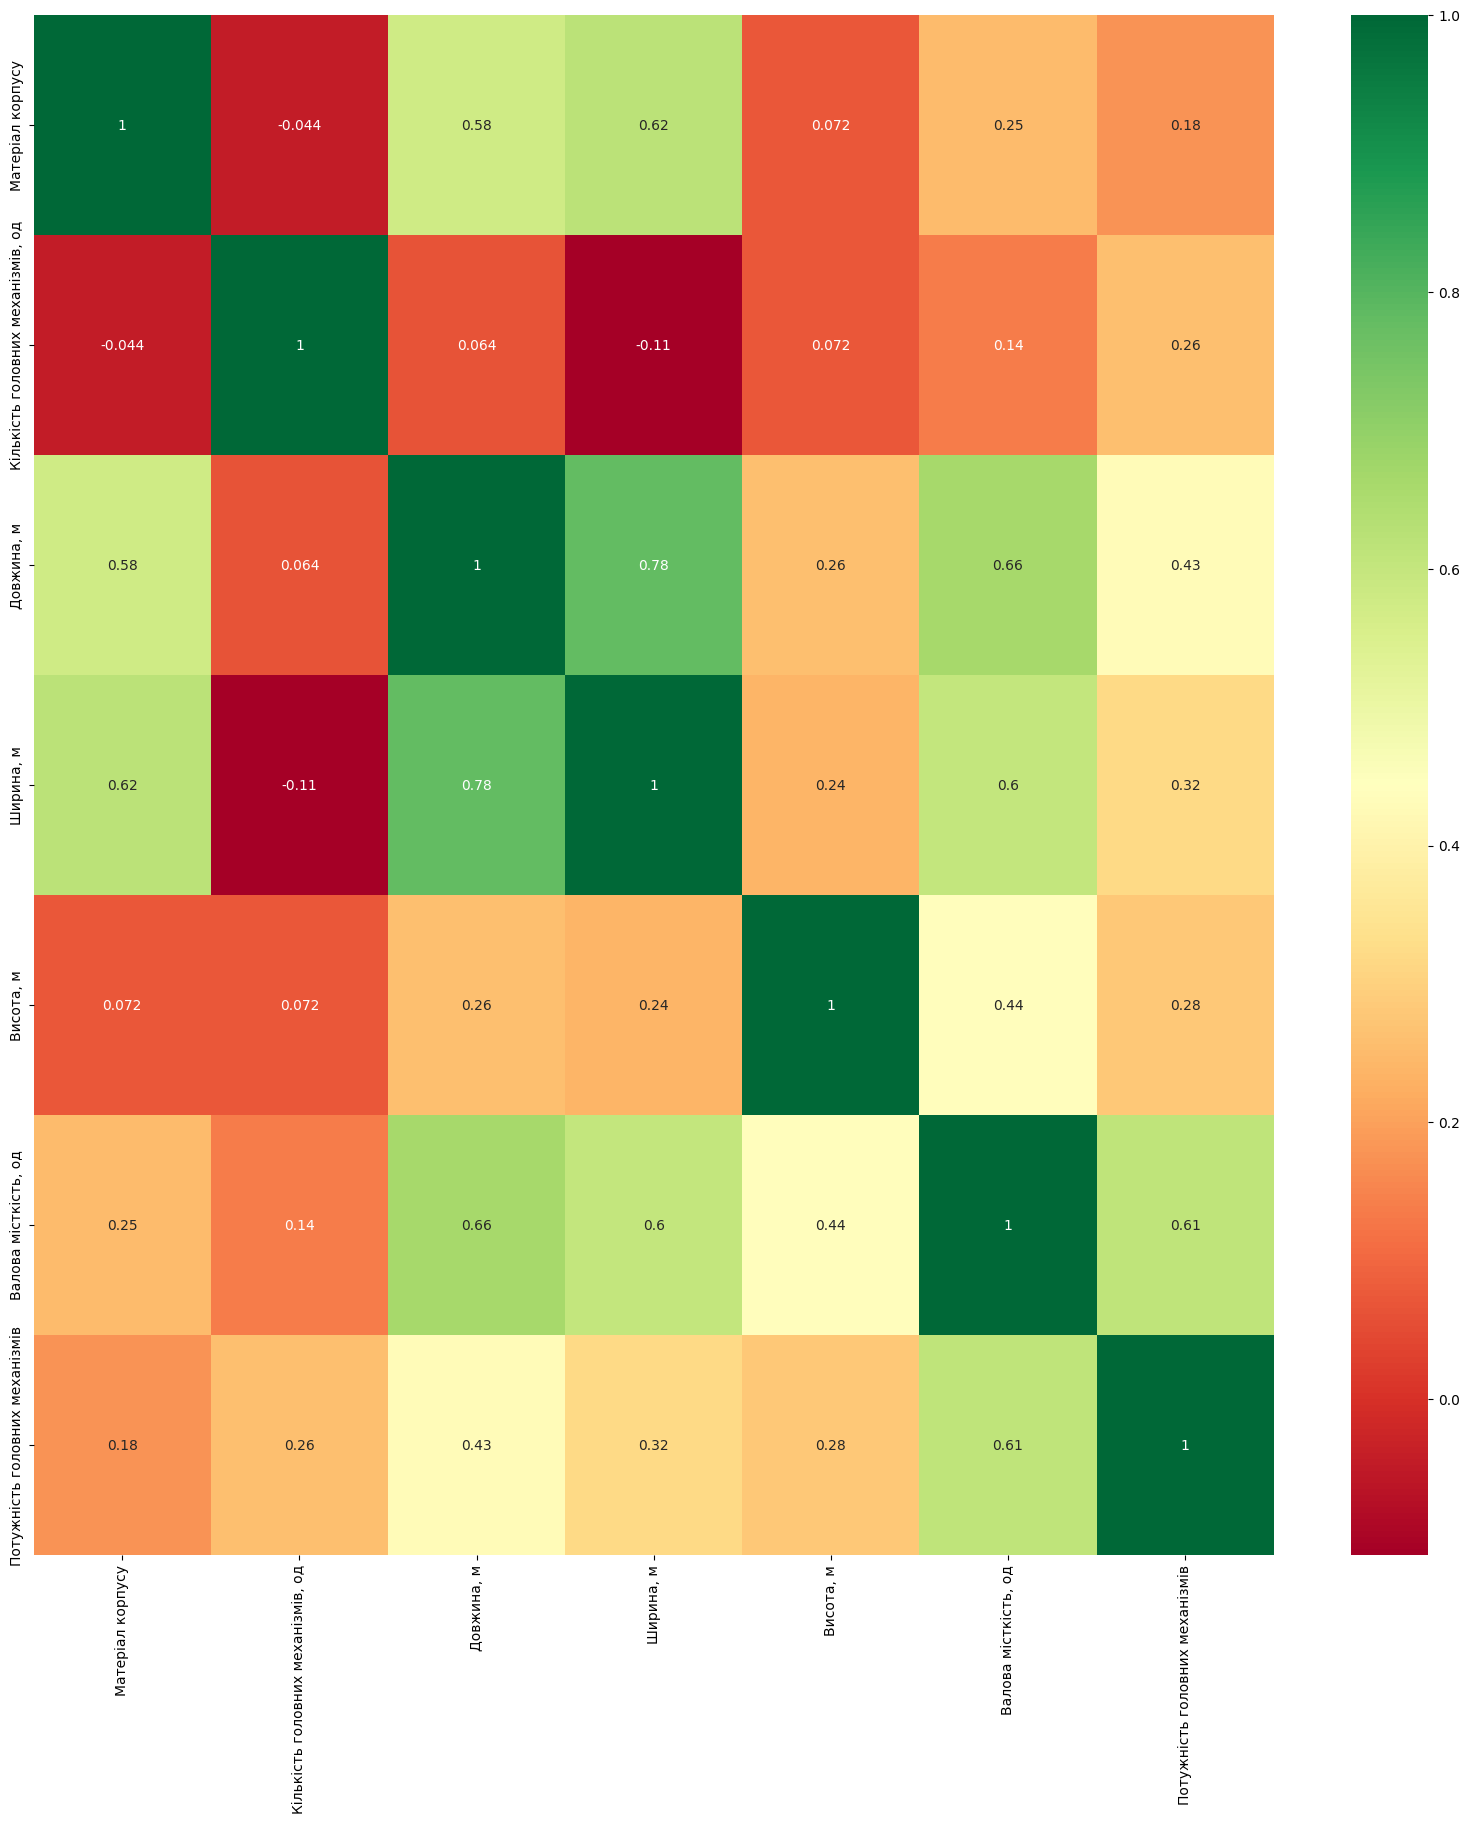

In [178]:
corrmat = x_enc.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(x_enc.corr(),annot=True,cmap="RdYlGn")

In [133]:
y_enc.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5578 entries, 0 to 5577
Series name: None
Non-Null Count  Dtype
--------------  -----
5578 non-null   int64
dtypes: int64(1)
memory usage: 43.7 KB


#### Compare metrics for different models

In [185]:
memo = {}

def get_metrics(x: pd.DataFrame, y: pd.Series, model: Any, label: str, use_memo: bool) -> dict:

    global memo

    if use_memo and label in memo:
        # print("FOUND")
        return memo[label]
    
    X_train, X_test, y_train, y_test = train_test_split(x_enc, y_enc, test_size=0.33, random_state=1)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    memo[label] = {"model": label,
            "accuracy": "%.2f" % metrics.accuracy_score(y_test, y_hat),
            "precision (macro)": "%.2f" % metrics.precision_score(y_test, y_hat, average = 'macro', zero_division=0),
            "precision (micro)": "%.2f" % metrics.precision_score(y_test, y_hat, average = 'micro', zero_division=0),
            "recall (macro)": "%.2f" % metrics.recall_score(y_test, y_hat, average = 'macro', zero_division=0),
            "recall (micro)": "%.2f" % metrics.recall_score(y_test, y_hat, average = 'micro', zero_division=0)}
    
    return memo[label]

In [34]:
# memo

In [186]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=1)
scoring = "accuracy"
jobs = 6

models = {"LogisticRegression": LogisticRegression(max_iter=2000),
          "LogisticRegression_grid": GridSearchCV(LogisticRegression(max_iter=2000),
                                                  param_grid={"penalty": ['l2'], "C": list(range(1,18))},
                                                  scoring=scoring,
                                                  cv=cv),
          
          "DecisionTreeClassifier": DecisionTreeClassifier(),
          "DecisionTreeClassifier_grid": GridSearchCV(DecisionTreeClassifier(),
                                                      param_grid={'max_depth': [5, 10, 20,25],
                                                                  'min_samples_leaf': [10, 20, 50, 100,120],
                                                                  'criterion': ["gini", "entropy"]},
                                                      scoring=scoring,
                                                      cv=cv),
          
          "SVC": SVC(kernel="linear", C=0.025),
          "SVC_grid": GridSearchCV(SVC(),
                                   param_grid={'C': [0.1, 1, 10, 100, 1000],
                                               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                               'kernel': ['rbf']}, #'sigmoid', 'poly']},
                                   scoring=scoring,
                                   refit = True,
                                   cv=cv,
                                   n_jobs=jobs),
          
          "KNN": KNeighborsClassifier(),
          "KNN_grid": GridSearchCV(KNeighborsClassifier(),
                              param_grid={'n_neighbors': range(1,31),
                                          'weights': ['uniform','distance']},
                              scoring=scoring,
                              cv=cv,
                              n_jobs=jobs),
          
          "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=0),
          "AdaBoost_grid": GridSearchCV(AdaBoostClassifier(),
                                        param_grid={'n_estimators': [100, 140, 145, 150, 160, 170, 175, 180, 185],
                                                    'learning_rate': [0.1, 1, 0.01, 0.5]},
                                        scoring=scoring,
                                        cv=cv,
                                        n_jobs=jobs),
                                                    
          "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
          "GradientBoosting_grid": GridSearchCV(GradientBoostingClassifier(random_state=0),
                                                param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
                                                            'n_estimators':[140, 150, 160],
                                                            'max_depth':[3, 4, 5]},
                                                scoring=scoring,
                                                cv=cv,
                                                n_jobs=jobs),
                                                
          "Bagging": BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0),
          "Bagging_grid": GridSearchCV(BaggingClassifier(estimator= SVC()),
                                       param_grid={'n_estimators': [10, 30, 50, 70, 80, 150, 160, 170, 175, 180, 185]},
                                       scoring=scoring,    
                                       cv=cv,
                                       n_jobs=jobs),
          
          "RandomForest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
          "RandomForest_grid": GridSearchCV(RandomForestClassifier(),
                                            param_grid={'n_estimators': [10, 50, 100, 500, 1000],
                                                        'max_depth': [2, 5, 7, 9, 10]},
                                            scoring=scoring,
                                            cv=cv,
                                            n_jobs=jobs)
         }

simple_models = [(k, models[k]) for k in models.keys() if not k.endswith("_grid")]
voting_model = VotingClassifier(estimators=simple_models, voting='hard')
models["Voting"] = voting_model

series = []
for label, model in models.items():
    print("Handling", label)
    series.append(pd.Series(get_metrics(x_enc, y_enc, model, label, False)))

mdf = pd.concat(series, axis=1).T.set_index("model")
mdf

Handling LogisticRegression
Handling LogisticRegression_grid
Handling DecisionTreeClassifier
Handling DecisionTreeClassifier_grid
Handling SVC
Handling SVC_grid
Handling KNN
Handling KNN_grid
Handling AdaBoost
Handling AdaBoost_grid
Handling GradientBoosting
Handling GradientBoosting_grid
Handling Bagging
Handling Bagging_grid
Handling RandomForest
Handling RandomForest_grid
Handling Voting


,accuracy,precision (macro),precision (micro),recall (macro),recall (micro)
model,,,,,
LogisticRegression,0.84,0.76,0.84,0.69,0.84
LogisticRegression_grid,0.84,0.76,0.84,0.69,0.84
DecisionTreeClassifier,0.89,0.84,0.89,0.79,0.89
DecisionTreeClassifier_grid,0.85,0.77,0.85,0.74,0.85
SVC,0.83,0.76,0.83,0.68,0.83
SVC_grid,0.88,0.81,0.88,0.77,0.88
KNN,0.86,0.79,0.86,0.78,0.86
KNN_grid,0.91,0.88,0.91,0.82,0.91
AdaBoost,0.82,0.72,0.82,0.67,0.82


#### Analyze best model

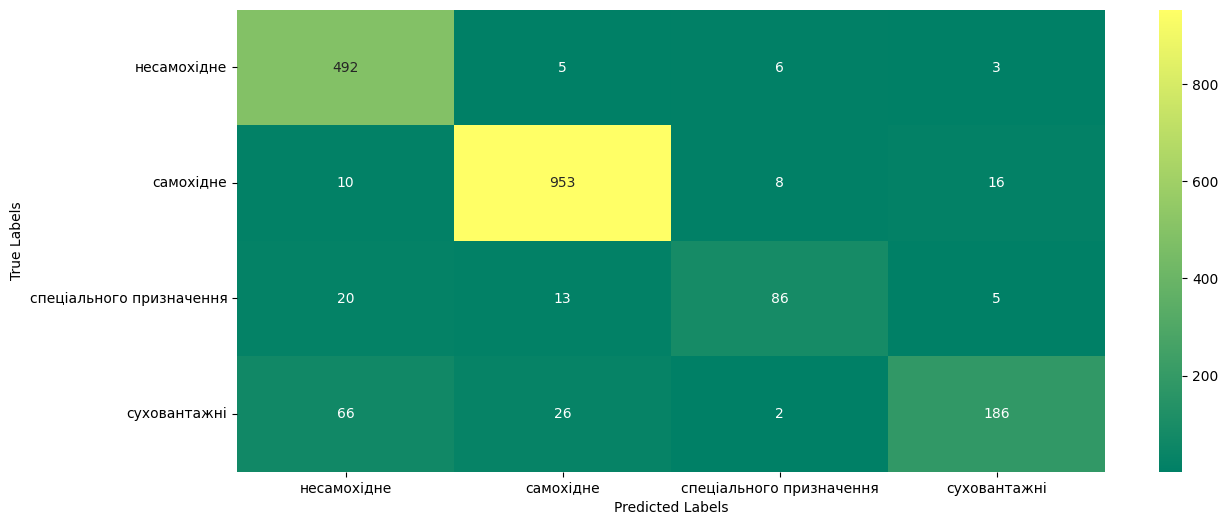

In [187]:
best_model = "KNN_grid" # KNN_grid
X_train, X_test, y_train, y_test = train_test_split(x_enc, y_enc, test_size=0.33, random_state=1)
y_hat = models[best_model].fit(X_train, y_train).predict(X_test)
y_score = models[best_model].fit(X_train, y_train).predict_proba(X_test)

plt.figure(figsize = (14,6))
sns.heatmap(metrics.confusion_matrix(y_test, y_hat), annot = True, fmt="d",
            xticklabels = le.classes_, yticklabels = le.classes_, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [188]:
print("Classes", le.classes_)
label_binarizer = preprocessing.LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

Classes ['несамохідне' 'самохідне' 'спеціального призначення' 'суховантажні']


(1897, 4)

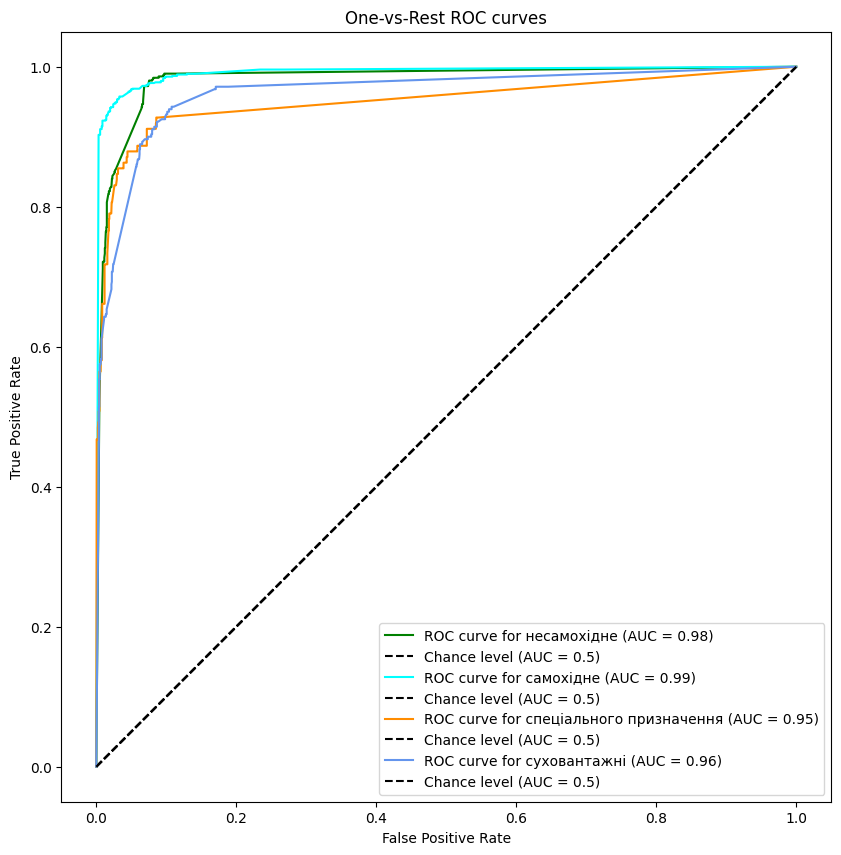

In [189]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = ["green", "aqua", "darkorange", "cornflowerblue"]
for class_id, class_ in enumerate(le.classes_):
    metrics.RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {class_}",
        color=colors[class_id],
        ax=ax,
        plot_chance_level=True,
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()